# Part C segmentation of imaging cytometry images

In [2]:
import os, sys
import cv2
import tqdm
import skimage as ski
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from skimage import measure
from skimage import filters
from skimage import morphology
from scipy import stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


**Convert the Part C files into .tif files, and place them in the same folder with the .ipynb file.**

In [2]:
print(sys.path)

['/Users/Clarisse/Documents/ENS 1  - L3/ENS 2 - M1/Mechanobiology-Group9/Project_2', '/Users/Clarisse/anaconda3/envs/ada/lib/python39.zip', '/Users/Clarisse/anaconda3/envs/ada/lib/python3.9', '/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/lib-dynload', '', '/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages']


In [3]:
FOLDER = os.getcwd()
FILES = os.listdir(FOLDER)
# remove .ipynb files from list
FILES = [f for f in FILES if f.endswith('.tif')]
print(FILES)

[]


In [49]:
# create the save folder
SAVE_FOLDER = os.path.join(FOLDER, 'segmented')
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

Select which file to use for the segmentation (optional)

In [54]:
# read video
filename = FILES[3]
test = io.imread(os.path.join(FOLDER, filename))
print(test.shape)

(4379, 256, 128)


## Single frame testing (optional, can skip this)

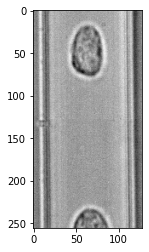

In [5]:
img = test[1]
plt.imshow(img, cmap='gray')
plt.show()

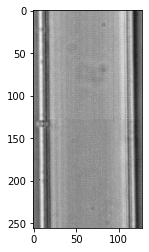

In [6]:
# compute the median over time
img_median = np.median(test[:100], axis=0)
plt.imshow(img_median, cmap='gray')
plt.show()

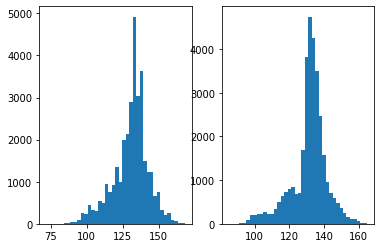

In [7]:
# check histogram of median image and the img
# side by side
plt.subplot(121)
plt.hist(img.flatten(), bins=40)
plt.subplot(122)
plt.hist(img_median.flatten(), bins=40)
plt.show()

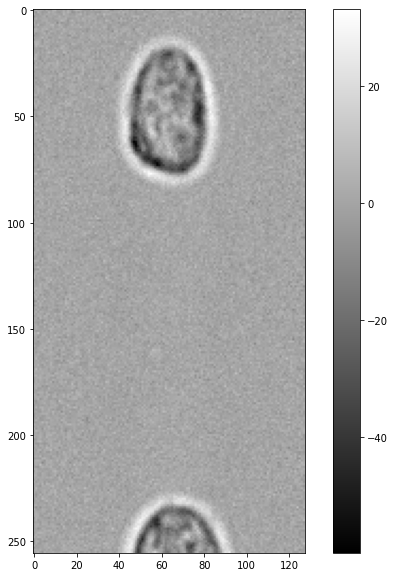

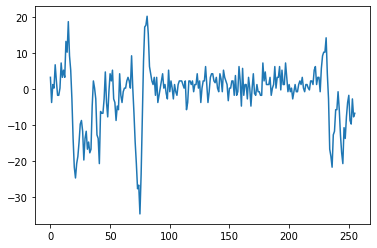

In [8]:
# subtract the average from each frame
img_sub = img - img_median
# center the image around 0
img_sub = img_sub - np.mean(img_sub)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_sub, cmap='gray')
plt.colorbar()
plt.show()

# show the intensity profile of y=100
plt.plot(img_sub[:, 65])
plt.show()

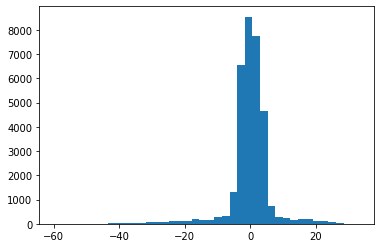

In [9]:
plt.hist(img_sub.flatten(), bins=40)
plt.show()

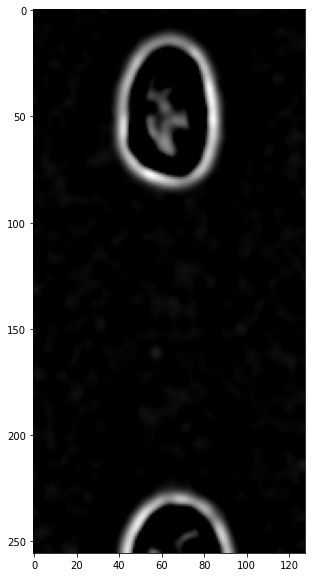

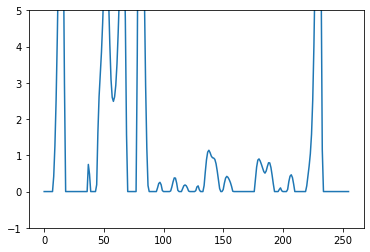

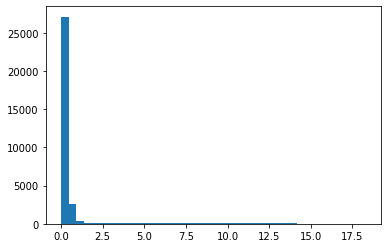

In [40]:
# remove high frequency noise with a gaussian filter
img_gauss = filters.difference_of_gaussians(img_sub, 2, 10)
img_gauss[img_gauss < 0] = 0
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_gauss, cmap='gray')
plt.show()

# show the intensity profile
plt.plot(img_gauss[:, 65])
plt.ylim(-1, 5)
plt.show()

# plot the histogram
plt.hist(img_gauss.flatten(), bins=40)
plt.show()

In [ ]:
# threshold the image by otus method
img_thresh = img_gauss > 1
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_thresh, cmap='gray')
plt.show()

In [ ]:
# fill holes
img_fill = morphology.remove_small_holes(img_thresh, area_threshold=10000)
img_fill = morphology.remove_small_objects(img_fill, min_size=1000)
# erode the image
img_fill = morphology.binary_erosion(img_fill, morphology.disk(5))
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_fill, cmap='gray')
plt.show()

In [ ]:
# apply cv2.findContours to find the contours

contours = cv2.findContours(img_fill.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# visualize the contours in bright yellow
plt.imshow(img, cmap='gray')
for contour in contours[0]:
    plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='yellow')
plt.show()


In [69]:
test = test[np.random.choice(test.shape[0], 100, replace=False)]
test.shape
# compute the median over time
img_median = np.median(test, axis=0)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_median, cmap='gray')
plt.show()

## Scale-up Segmentation (optional, proceed from here to do the segmentation)

Define the function to get the segmentation mask from the image.

Image processing workflow:
- Background subtraction: 100 random frames are used to calculate the background image (median) and subtracted from the time stack.
- Bandpass filtering: difference of Gaussian (DoG) filter is applied to the background subtracted image.
- Intensity thresholding: pixels with intensity above the threshold are considered as foreground.
- Morphological operations: remove small objects and fill holes, then erode the final mask to narrow the boundary.

In [55]:
class rtfc_seg:
    def __init__(self, img_stack, int_thres, area_thres):
        self.img_stack = img_stack
        self.fill_stack = np.zeros(img_stack.shape, dtype=bool)
        self.int_thres = int_thres
        self.area_thres = area_thres
        self.contourList = []
        
    def seg(self):
        # take a better background
        # randomly take 100 frames from the img_stack and compute the median
        img_median = np.median(self.img_stack[np.random.choice(self.img_stack.shape[0], 100, replace=False)], axis=0)
        # subtract the img_median from the img_stack
        # img_stack is a 3D array, img_median is a 2D array
        # subtraction is done in the 2,3 dimension of img_stack
        img_stack_sub = self.img_stack - img_median
        # center each frame around 0
        img_stack_sub = img_stack_sub - np.mean(img_stack_sub, axis=(1,2))[:, np.newaxis, np.newaxis]
        # loop through each frame and perform segmentation
        for tf in tqdm.tqdm(range(img_stack_sub.shape[0])):
            img_gauss = filters.difference_of_gaussians(img_stack_sub[tf,:,:], 2, 10)
            #img_gauss[img_gauss < 0] = 0
            img_thres = img_gauss > self.int_thres
            img_thres = img_thres.astype(bool)
            self.fill_stack[tf,:,:] = morphology.remove_small_holes(img_thres, area_threshold=self.area_thres)
            # remove small objects
            self.fill_stack[tf,:,:] = morphology.remove_small_objects(self.fill_stack[tf,:,:], min_size=500)
            # erode the image
            self.fill_stack[tf,:,:] = morphology.binary_erosion(self.fill_stack[tf,:,:], morphology.disk(5))
            # find contours
            contour = cv2.findContours(self.fill_stack[tf,:,:].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            self.contourList.append(contour)

In [56]:
rseg = rtfc_seg(test, 1, 10000)
rseg.seg()

100%|██████████| 4379/4379 [00:53<00:00, 82.48it/s] 


In [57]:
# save the fill stack
ski.io.imsave(os.path.join(SAVE_FOLDER, filename[:-4] + '_seg.tif'), (rseg.fill_stack*255).astype(np.uint8), plugin='tifffile')

Randomly visualize 100 frames from the time stack.

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 22.01it/s]


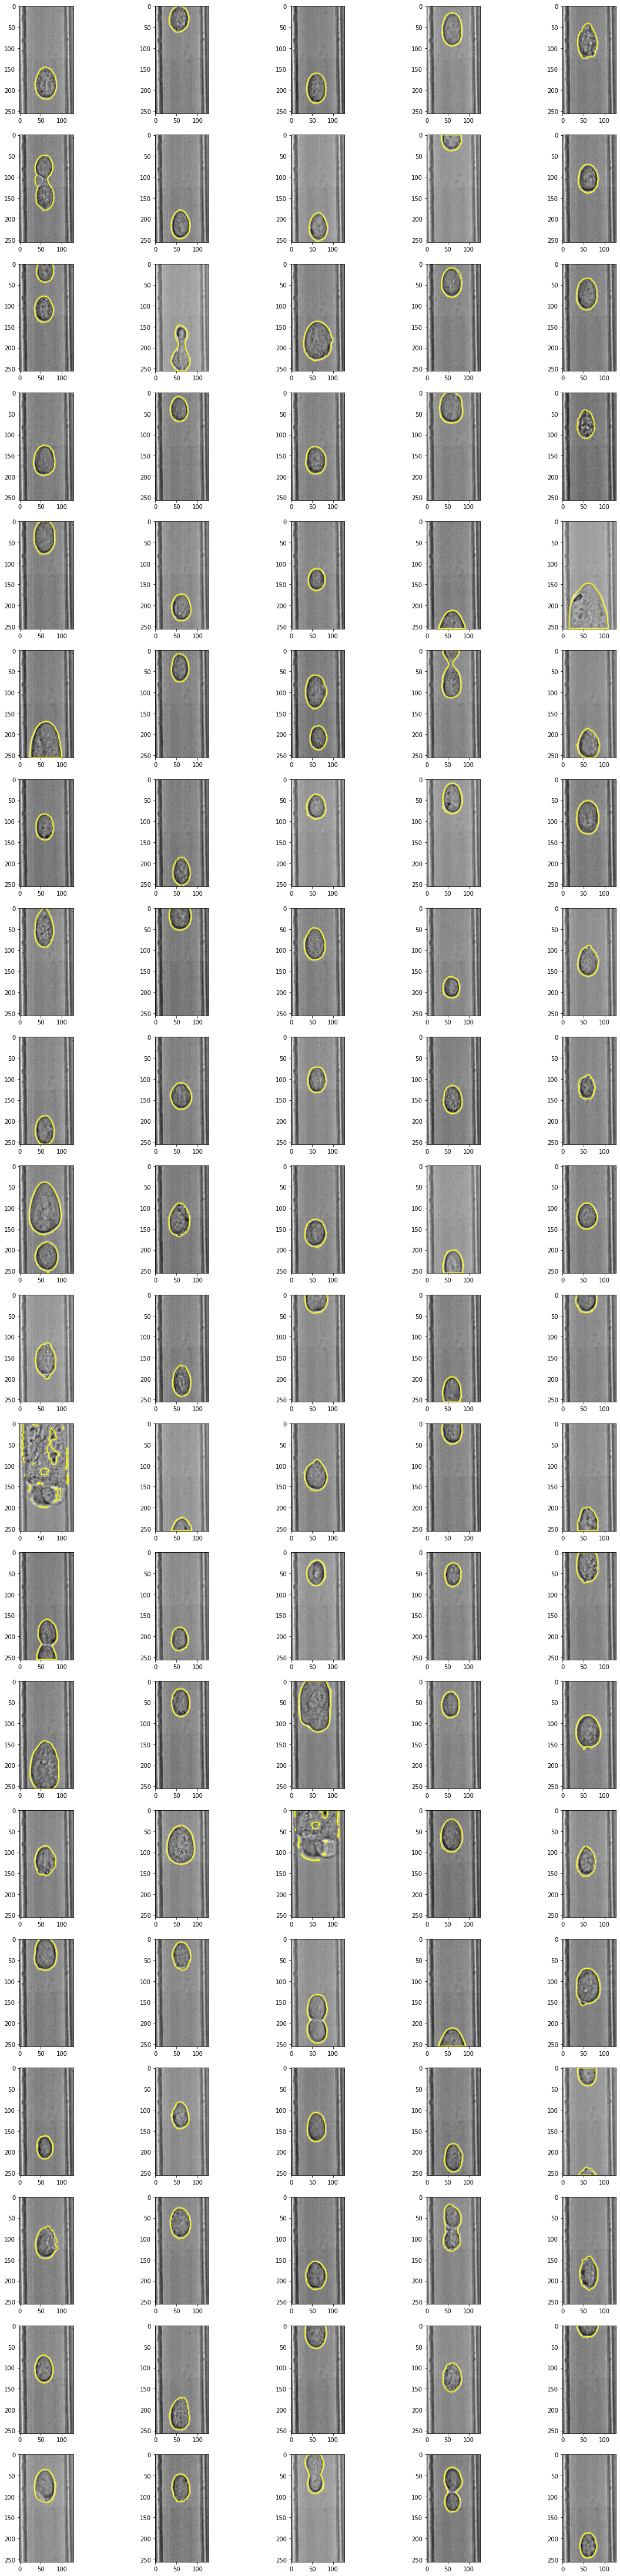

In [77]:
# randomly visualize 100 in subplot 20 by 5
# show with contour
plt.figure(figsize = (20, 80))
# pick 100 random frames
frames = np.random.randint(0, test.shape[0], 100)
for i in tqdm.tqdm(range(100)):
    plt.subplot(20, 5, i+1)
    plt.imshow(rseg.img_stack[frames[i], :, :], cmap='gray')
    for contour in rseg.contourList[frames[i]][0]:
        plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='yellow')
plt.show()

## Visualization (proceed from here to visualize the segmentation if you have the csv files)

Read the measurement results from the .csv file.

In [59]:
CSV_LIST = os.listdir(SAVE_FOLDER)
# keep only csv files
CSV_LIST = [f for f in CSV_LIST if f.endswith('.csv')]
print(CSV_LIST)

['CellA_GFP_seg.csv', 'CellA_ShME480_seg.csv', 'CellB_GFP_seg.csv', 'CellB_ME480_seg.csv']


Plot the scatter plot with 50% density contour.

In [33]:
def get_density(x, y):
    """Get kernal density estimate for each (x, y) point."""
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    density = kernel(values)
    return density

In [60]:
# read the csv file
df_big = pd.DataFrame()
colorlist = ['red', 'yellow', 'gray', 'orange']
cmap = dict()

for filename in CSV_LIST:
    df = pd.read_csv(os.path.join(SAVE_FOLDER, filename), index_col=0)
    # append the filename to the dataframe with additional column 'filename'
    df['filename'] = filename[:-4]
    # append the dataframe to df_big
    df_big = df_big.append(df)
    cmap[filename[:-4]] = colorlist[CSV_LIST.index(filename)]

In [61]:
# add 1-Circ to the dataframe
for key in df_big:
    df_big['Deform.'] = 1-df_big['Circ.']

In [62]:
df_big['filename'].unique()

array(['CellA_GFP_seg', 'CellA_ShME480_seg', 'CellB_GFP_seg',
       'CellB_ME480_seg'], dtype=object)

In [63]:
display(df_big)

,Area,Circ.,Slice,AR,Round,Solidity,filename,Deform.
,,,,,,,,
1,2394,0.831,1,1.552,0.644,0.969,CellA_GFP_seg,0.169
2,2394,0.849,2,1.546,0.647,0.973,CellA_GFP_seg,0.151
3,2812,0.837,3,1.339,0.747,0.958,CellA_GFP_seg,0.163
4,2020,0.774,6,1.769,0.565,0.952,CellA_GFP_seg,0.226
5,3358,0.876,7,1.380,0.725,0.976,CellA_GFP_seg,0.124
...,...,...,...,...,...,...,...,...
3090,1741,0.872,4374,1.381,0.724,0.967,CellB_ME480_seg,0.128
3091,3368,0.704,4375,2.011,0.497,0.947,CellB_ME480_seg,0.296
3092,3551,0.838,4376,1.512,0.661,0.968,CellB_ME480_seg,0.162


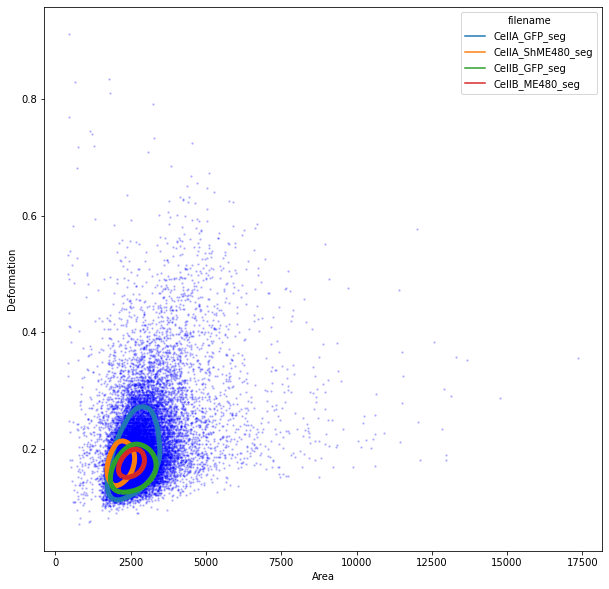

In [64]:
# plot scatter plot of area vs. 1-Circ.
fig = plt.figure(figsize=(10, 10))
x = df_big['Area'].values
y = df_big['Deform.'].values
plt.scatter(x, y, s=2, color = 'b', alpha=0.2)
kde = sns.kdeplot(data = df_big, x='Area', y='Deform.', levels=[0.5], alpha=1, linewidths=5, hue='filename')
plt.xlabel('Area')
plt.ylabel('Deformation')
plt.show()

### Plot deformation metrics for the different strains

In [3]:
# Concatenate all dataframes into only one

A_GFP=pd.read_csv('/Users/Clarisse/EPFL_MA1/Mechanobio/CellA_GFP_seg.csv')
B_GFP=pd.read_csv('/Users/Clarisse/EPFL_MA1/Mechanobio/CellB_GFP_seg.csv')
A_ShME480=pd.read_csv('/Users/Clarisse/EPFL_MA1/Mechanobio/CellA_ShME480_seg.csv')
B_ME480=pd.read_csv('/Users/Clarisse/EPFL_MA1/Mechanobio/CellB_ME480_seg.csv')

A_GFP['cond']=['A_GFP' for cell in range (0,len(A_GFP))]
B_GFP['cond']=['B_GFP' for cell in range (0,len(B_GFP))]
A_ShME480['cond']=['A_shME480' for cell in range (0,len(A_ShME480))]
B_ME480['cond']=['B_ME480' for cell in range (0,len(B_ME480))]

data1=pd.concat([A_GFP,A_ShME480,B_GFP,B_ME480])


# save the resulting dataframe as a csv

data1.to_csv('data/dataC.csv')


/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<AxesSubplot:xlabel='cond', ylabel='Slice'>

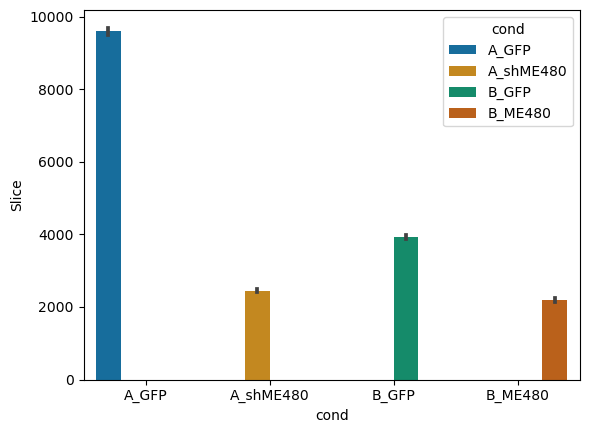

In [4]:
# Plotting
sns.set_palette('colorblind')
sns.barplot(data=data1,x='cond',y='Slice',hue='cond')

/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Clarisse/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

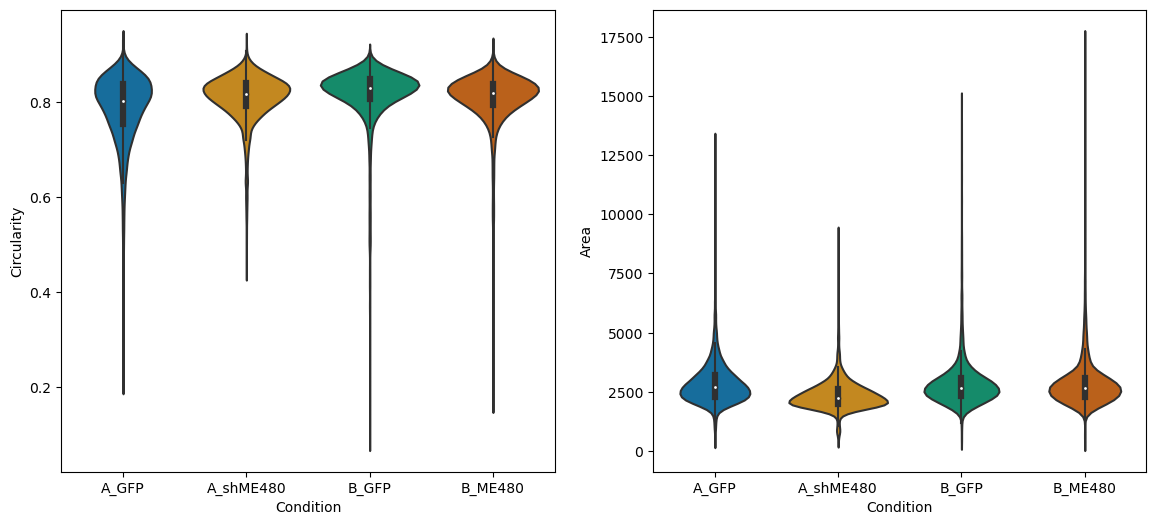

In [7]:
metrics=['Circ.','Area']
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,6))

i=0
for met in metrics:
    sns.violinplot(data=data1,x="cond",y=met,ax=axes[i])
    i+=1

axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Circularity")

axes[1].set_xlabel("Condition")
axes[1].set_ylabel("Area")

#plt.tight_layout()
plt.savefig('Figures/PartC_metrics.png')